<a href="https://colab.research.google.com/github/mindadeepam/CIFAR-10-Object-Recognition-in-Images/blob/main/basic_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [2]:
# !pip install py7zr

In [3]:
import tensorflow as tf
import tensorflow.keras as keras

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

## load dataset

In [5]:
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.cifar10.load_data()

In [6]:
xtrain.shape, ytrain.shape

((50000, 32, 32, 3), (50000, 1))

In [7]:
np.unique(ytrain, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [8]:
classes =	['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
def plot_sample(i):
  plt.imshow(xtrain[i])
  plt.xlabel(classes[ytrain[i]])

## utils

In [10]:
# transformer = Normalizer().fit(xtrain)
def normalize(x):
  return x/255

In [33]:
def plot_metrics(history, suptitle="Model"):
  metrics = ['loss', 'accuracy']
  plt.figure(figsize=(15,15))
  plt.suptitle(f'Model')
  colors = ["#c52c1b", "#b753ea", "#13dd13", "#00ccff"]

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[n], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[n], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([plt.ylim()[0]-.1, 2])
    elif metric == 'auc' or metric == 'prc':
      plt.ylim([plt.ylim()[0]-.1, 1])
    else:
      plt.ylim([plt.ylim()[0]-.1, plt.ylim()[1]+.1])

    plt.legend();
    plt.savefig(f'Model_train_metrics.png') 

## preprocessing

In [12]:
xtrain[5:10,:,:,:].shape

(5, 32, 32, 3)

In [13]:
xtrain = normalize(xtrain)
xtest = normalize(xtest)

In [14]:
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))

AUTOTUNE = tf.data.AUTOTUNE
batch_size=32
train_ds = train_ds.shuffle(buffer_size=len(train_ds))\
              .batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)


In [15]:
test_ds = tf.data.Dataset.from_tensor_slices((xtest, ytest))
AUTOTUNE = tf.data.AUTOTUNE
batch_size=32
test_ds = test_ds.shuffle(buffer_size=len(test_ds))\
              .batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

## ANN model

In [16]:
def create_ann():
  base_model = tf.keras.Sequential()
  base_model.add(Flatten(input_shape=(32,32,3)))
  base_model.add(Dense(1024, activation='relu'))
  base_model.add(Dropout(0.5))
  base_model.add(Dense(256, activation="relu"))
  base_model.add(Dropout(0.5))
  base_model.add(Dense(64, activation="relu"))
  base_model.add(Dense(10, activation='softmax'))

  base_model.compile(metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy())
  
  return base_model

In [17]:
create_ann().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 10)                6

### untrained model - baseline

In [18]:
base_model = create_ann()
ypred=base_model.predict(xtrain)

In [19]:
predictions = np.array([np.argmax(element) for element in ypred])
predictions = predictions.reshape(-1,1)
assert ytrain.shape == predictions.shape
print(classification_report(ytrain, predictions))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5000
           1       0.11      0.16      0.13      5000
           2       0.13      0.31      0.18      5000
           3       0.13      0.01      0.02      5000
           4       0.02      0.00      0.01      5000
           5       0.17      0.00      0.00      5000
           6       0.09      0.38      0.15      5000
           7       0.05      0.01      0.02      5000
           8       0.07      0.10      0.08      5000
           9       0.00      0.00      0.00      5000

    accuracy                           0.10     50000
   macro avg       0.08      0.10      0.06     50000
weighted avg       0.08      0.10      0.06     50000



### ann model performance

In [20]:
histories = {"ann": {},
             "cnn": {}}

In [21]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
checkpoint_filepath = f'ann_checkpoint/model_checkpoint'  
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_filepath,
  save_weights_only=True,
  monitor='val_loss',
  mode='min',
  save_best_only=True)

history = base_model.fit(train_ds, validation_data=test_ds, epochs=100, callbacks=[stop_early, model_checkpoint])
histories['ann']["history"] = history


Epoch 1/100
1563/1563 [==============================] - 11s 6ms/step - loss: 2.1192 - accuracy: 0.2093 - val_loss: 1.9361 - val_accuracy: 0.2955
Epoch 2/100
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9307 - accuracy: 0.2938 - val_loss: 1.8252 - val_accuracy: 0.3424
Epoch 3/100
1563/1563 [==============================] - 10s 6ms/step - loss: 1.8687 - accuracy: 0.3249 - val_loss: 1.7606 - val_accuracy: 0.3794
Epoch 4/100
1563/1563 [==============================] - 7s 4ms/step - loss: 1.8266 - accuracy: 0.3412 - val_loss: 1.7211 - val_accuracy: 0.3900
Epoch 5/100
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7889 - accuracy: 0.3575 - val_loss: 1.6881 - val_accuracy: 0.4124
Epoch 6/100
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7665 - accuracy: 0.3674 - val_loss: 1.6470 - val_accuracy: 0.4257
Epoch 7/100
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7417 - accuracy: 0.3790 - val_loss: 1.6380 - val_

In [25]:
## load best model from checkpoint and evaluate against test data
loaded_cnn = create_ann()
loaded_cnn.load_weights(checkpoint_filepath)

ypred=base_model.predict(xtrain)
predictions = np.array([np.argmax(element) for element in ypred])
predictions = predictions.reshape(-1,1)
histories['ann']['test_accuracy'] = base_model.evaluate(train_ds)

1563/1563 [==============================] - 5s 3ms/step - loss: 1.2263 - accuracy: 0.5792


In [23]:
## e-2 too high LR - No learning
# history = base_model.fit(train_ds, epochs=50)
# histories['1e-2'] = history

## CNN model

In [26]:
def create_cnn():
  cnn_model = tf.keras.Sequential()
  cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu'))
  cnn_model.add(MaxPool2D((2, 2)))
  cnn_model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
  cnn_model.add(MaxPool2D((2, 2)))
  cnn_model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
  cnn_model.add(MaxPool2D((2, 2)))
  cnn_model.add(Flatten())
  cnn_model.add(Dense(128, activation='relu'))
  cnn_model.add(Dropout(0.3))
  cnn_model.add(Dense(32, activation='relu'))
  cnn_model.add(Dropout(0.3))
  cnn_model.add(Dense(10, activation='softmax'))
  # cnn_model.add(MaxPool2D((2, 2)))

  cnn_model.compile(metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False))
  
  return cnn_model

In [27]:
## callbacks
checkpoint_filepath = f'cnn_checkpoint/model_checkpoint'  
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_filepath,
  save_weights_only=True,
  monitor='val_loss',
  mode='min',
  save_best_only=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

## train model
cnn_model = create_cnn()
history = cnn_model.fit(train_ds, validation_data=test_ds, epochs=100, callbacks=[stop_early,model_checkpoint])

Epoch 1/100
1563/1563 [==============================] - 18s 5ms/step - loss: 1.9494 - accuracy: 0.2672 - val_loss: 1.6346 - val_accuracy: 0.4188
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6597 - accuracy: 0.3889 - val_loss: 1.4379 - val_accuracy: 0.4952
Epoch 3/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5099 - accuracy: 0.4549 - val_loss: 1.3064 - val_accuracy: 0.5346
Epoch 4/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4080 - accuracy: 0.4957 - val_loss: 1.2658 - val_accuracy: 0.5479
Epoch 5/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3223 - accuracy: 0.5311 - val_loss: 1.1556 - val_accuracy: 0.5910
Epoch 6/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2515 - accuracy: 0.5605 - val_loss: 1.1069 - val_accuracy: 0.6116
Epoch 7/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1886 - accuracy: 0.5843 - val_loss: 1.0839 - val_a

In [28]:
## load best model from checkpoint and evaluate against test data
loaded_cnn = create_cnn()
loaded_cnn.load_weights(checkpoint_filepath)


cnn_y = loaded_cnn.predict(xtrain)
cnn_predictions = np.array([np.argmax(element) for element in cnn_y])
cnn_predictions = predictions.reshape(-1,1)
cnn_accuracy = loaded_cnn.evaluate(train_ds)

1563/1563 [==============================] - 7s 3ms/step - loss: 0.5531 - accuracy: 0.8121


In [29]:
histories['cnn']['history'] = history

In [31]:
print(classification_report(ytrain, cnn_predictions))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62      5000
           1       0.73      0.69      0.71      5000
           2       0.48      0.33      0.39      5000
           3       0.44      0.42      0.43      5000
           4       0.46      0.59      0.51      5000
           5       0.53      0.38      0.44      5000
           6       0.53      0.72      0.61      5000
           7       0.68      0.66      0.67      5000
           8       0.71      0.71      0.71      5000
           9       0.63      0.68      0.65      5000

    accuracy                           0.58     50000
   macro avg       0.58      0.58      0.57     50000
weighted avg       0.58      0.58      0.57     50000



## plot metrics

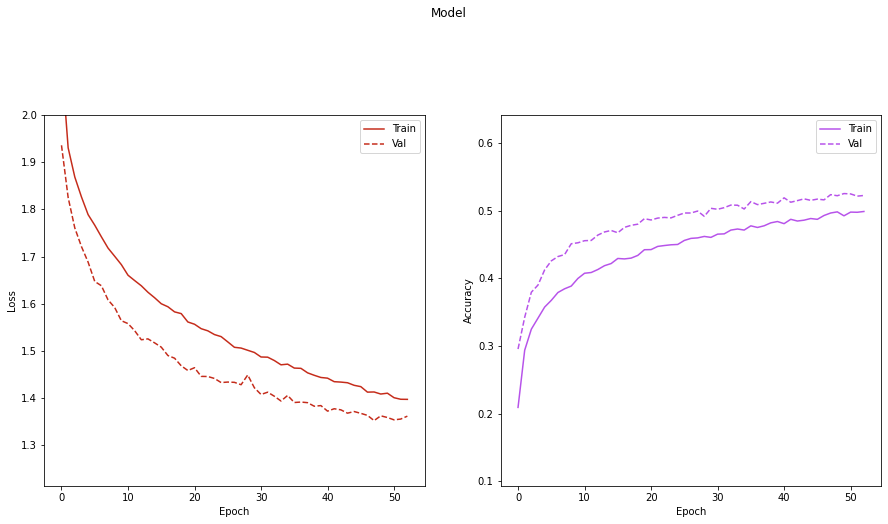

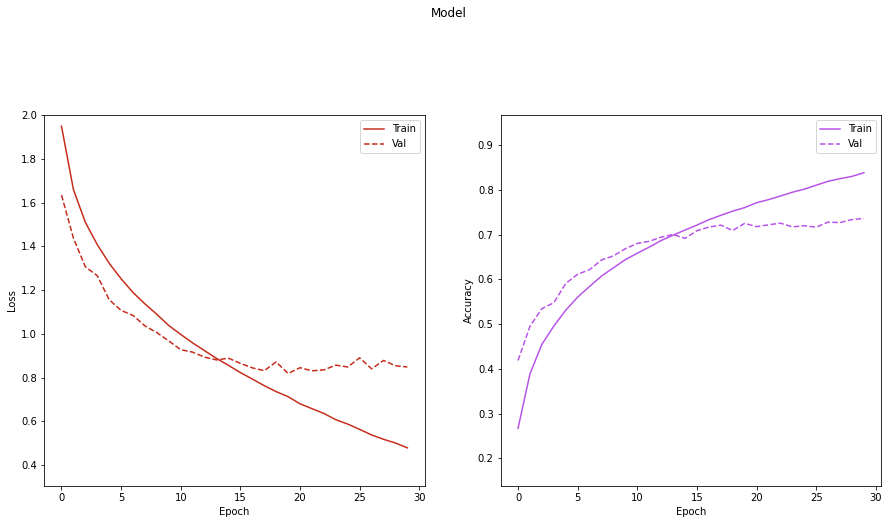

In [34]:
plot_metrics(histories['ann']['history'], suptitle="ANN Model")
plot_metrics(histories['cnn']['history'], suptitle="CNN Model")